# Quickly plot target images

In [1]:
import sys

import numpy as np
from matplotlib import pyplot as plt
import proplot as pplt
from scipy import signal

import target_image_analysis as tis

sys.path.append('/Users/46h/Research/')
from scdist.tools import utils

In [2]:
pplt.rc['grid.alpha'] = 0.05
pplt.rc['axes.grid'] = False
pplt.rc['figure.facecolor'] = 'white'
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'mono_r'

## Load files

In [3]:
folder = '_output/data/'
filenames = utils.list_files(folder)
filenames = [f for f in filenames if 'image' in f]
images = tis.read_files(filenames, n_avg='all', make_square=False)

In [4]:
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

def detect_peaks(image):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # Define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2, 2)

    # Apply the local maximum filter; all pixel of maximal value 
    # in their neighborhood are set to 1.
    local_max = maximum_filter(image, footprint=neighborhood)==image
    
    # Local_max is a mask that contains the peaks we are looking for, but 
    # also the background. In order to isolate the peaks we must remove 
    # the background from the mask.

    # We create the mask of the background
    background = image == 0

    # A little technicality: we must erode the background in order to 
    # successfully subtract it form local_max. Otherwise, a line will 
    # appear along the background border (artifact of the local maximum filter).
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    # We obtain the final mask, containing only peaks, by removing the background from 
    # the local_max mask (xor operation)
    detected_peaks = local_max & eroded_background

    return detected_peaks

In [5]:
from scipy import signal
from scipy import spatial
from scipy import interpolate
from skimage import filters

In [6]:
def find_peaks(Z, **kws):
    col_indices = [signal.find_peaks(row, **kws)[0] for row in Z]
    row_indices = [signal.find_peaks(col, **kws)[0] for col in Z.T]
    xidx, yidx = [], []
    for i in trange(Z.shape[0]):
        for j in range(Z.shape[1]):
            if i in row_indices[j] and j in col_indices[i]:
                xidx.append(i)
                yidx.append(j)
    xidx = np.array(xidx)
    yidx = np.array(yidx)
    return xidx, yidx

In [7]:
# from tqdm import trange

# image = images[0]
# Z = np.copy(image.Z)

# # vmin = np.percentile(Z, 5)
# # vmax = np.percentile(Z, 99)
# # Z = np.clip(Z, vmin, vmax)

# kws = dict(width=1, height=50)
# xidx, yidx = find_peaks(Z, **kws)
# xidx_dark, yidx_dark = find_peaks(-Z, width=1, prominence=10)
        
# # Average neighbors
# w = 2
# arrays = []
# for i in range(-w, w + 1):
#     for j in range(-w, w + 1):
#         if i != j:
#             arrays.append(Z[np.ix_(xidx_dark + i, yidx_dark + j)])
# Znew = np.copy(Z)
# Znew[np.ix_(xidx_dark, yidx_dark)] = np.sum(arrays, axis=0) / len(arrays)
# # Znew = filters.gaussian(Znew.T, 0.0)

# sigma = 3.0
# fig, axes = pplt.subplots(nrows=4, figwidth=5.0)
# axes[0].pcolormesh(image.xx, image.yy, Z.T, ec='none')
# axes[1].pcolormesh(image.xx, image.yy, filters.gaussian(Z.T, sigma), ec='none')
# axes[2].pcolormesh(image.xx, image.yy, Znew.T, ec='none')
# axes[3].pcolormesh(image.xx, image.yy, filters.gaussian(Znew.T, sigma), ec='none')
# # axes[0].scatter(image.xx[xidx], image.yy[yidx], s=0.25, c='red')
# axes[0].scatter(image.xx[xidx_dark], image.yy[yidx_dark], s=0.25, c='red')
# axes.format(aspect=1.0)
# plt.show()

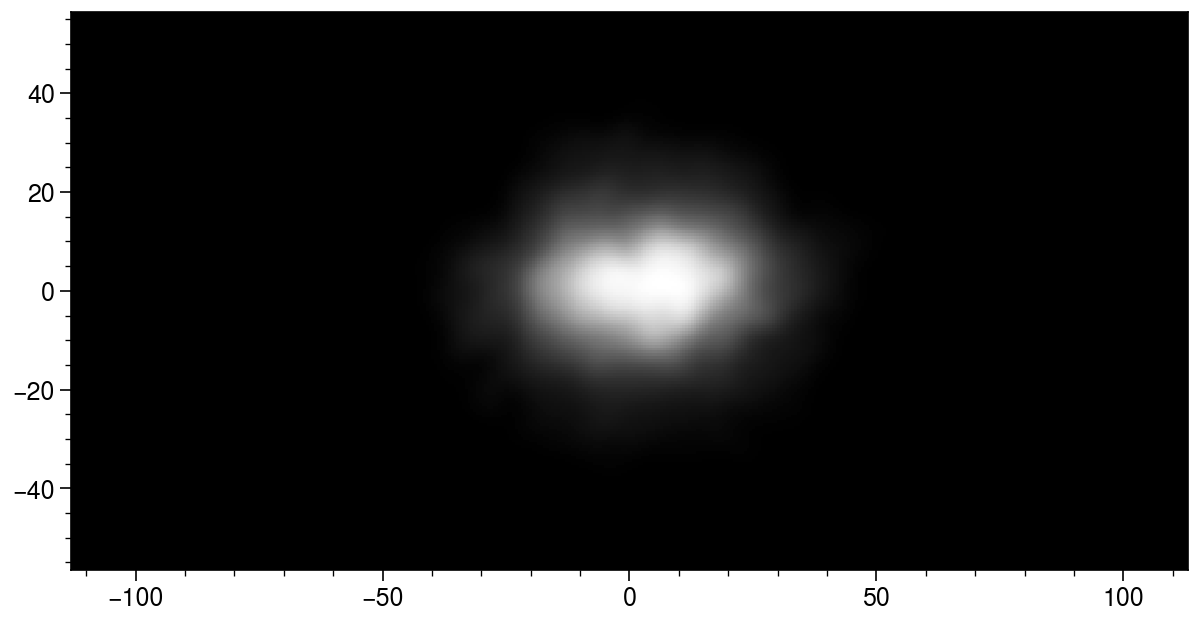

In [11]:
fig, ax = pplt.subplots(figwidth=6)
image = images[0]
Z = np.copy(image.Z)

indices = [(160, 65),
          (155, 135),
          (275, 65),
          (260, 135),
         ]
radius = 5.0
X, Y = np.meshgrid(image.xx, image.yy, indexing='ij')
_xind = []
_yind = []
for (i, j) in indices:
    R = np.sqrt((X - image.xx[i])**2 + (Y - image.yy[j])**2)
    xidx, yidx = np.where(R <= radius)
    _xind.append(xidx)
    _yind.append(yidx)
#     Z[xidx, yidx] += 30.0
#     Z[xidx, yidx] += np.abs(np.random.normal(loc=10.0, scale=10))

ax.pcolormesh(image.xx, image.yy, filters.gaussian(Z.T, 4.0), robust=False)
# for (xidx, yidx) in zip(_xind, _yind):
#     ax.scatter(image.xx[xidx], image.yy[yidx], s=2, c='red', ec='none')

ax.format(aspect=1.0)
plt.show()

In [ ]:
peaks = np.vstack([image.xx[xidx], image.yy[yidx]]).T
valleys = np.vstack([image.xx[xidx_dark], image.yy[yidx_dark]]).T
# tri = spatial.Delaunay(peaks)
# tri.points

In [ ]:
# from matplotlib.tri import Triangulation, LinearTriInterpolator, CubicTriInterpolator

# def get_grid_coords(*xi, indexing='ij'):
#     """Return array of shape (N, D), where N is the number of points on 
#     the grid and D is the number of dimensions."""
#     return np.vstack([X.ravel() for X in np.meshgrid(*xi, indexing='ij')]).T


# tri = Triangulation(image.xx[xidx], image.yy[yidx])
# f = LinearTriInterpolator(tri, Z[xidx, yidx])

# Znew = np.zeros(Z.shape)
# for i in range(Z.shape[0]):
#     for j in range(Z.shape[1]):
#         Znew[i, j] = f(image.xx[i], image.yy[j])
# Znew[np.isnan(Znew)] = 0

In [ ]:
# Transform the grid coordinates.
coords = peaks
coords_int = valleys
# coords_int = get_grid_coords(image.xx, image.yy)

Znew = np.copy(Z)
Znew[xidx_dark, yidx_dark] = interpolate.griddata(coords, Z[xidx, yidx], coords_int, method='linear')
# Znew[np.isnan(Znew)] = 0.0
# Znew = Znew.reshape(Z.shape)
# return Z, new_grid

In [ ]:
fig, ax = pplt.subplots(figwidth=5.0)
# Znew = filters.gaussian(Znew, 3.0)
ax.pcolormesh(image.xx, image.yy, Znew.T, ec='none')
ax.format(aspect=1.0)
plt.show()

## Plot 

In [ ]:
n_turns_list = list(range(50, 550, 50))
sigma = 3.0
for image in images:
    fig, axes = pplt.subplots(ncols=2, figsize=(8, 2.5))
    axes[0].pcolormesh(image.xx, image.yy, image.Z.T)
    axes[1].pcolormesh(image.xx, image.yy, image.filter(sigma).T)
    axes[0].set_title('Raw')
    axes[1].set_title(r'Gaussian blur ($\sigma = {}$)'.format(sigma))
    axes.format(xlabel='x [mm]', ylabel='y [mm]', aspect=1.0)